# Import libraries

# START FROM HERE

## 1) IMPORTS

### 1.a) Importing libraries

In [ ]:
### ====== Import python essential libraries ====== ###

import pandas as pd
import numpy as np

### ====== import sklearn essentials ====== ###

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler ,  OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

### ====== Import the ensemble ====== ###

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier


### ====== Import graphic libraries ====== ###

import matplotlib.pyplot as plt



### 1.b) Importing the data

In [ ]:
df = pd.read_csv('conversion_data_train.csv')

## 2) Data Preparations and Preprocessing

### 2.a) EDA

In [ ]:
print('1) A sample of the dataset:')
print(df.head())
print()

print('2) Dataset description')
print(df.describe())
print()

print('3) Percentage of missing values:')
print(df.isna().sum()/df.shape[0]*100)
print()

print('4) Dataset shape :', df.shape)

1) A sample of the dataset:
   country  age  new_user  source  total_pages_visited  converted
0    China   22         1  Direct                    2          0
1       UK   21         1     Ads                    3          0
2  Germany   20         0     Seo                   14          1
3       US   23         1     Seo                    3          0
4       US   28         1  Direct                    3          0

2) Dataset description
                 age       new_user  total_pages_visited      converted
count  284580.000000  284580.000000        284580.000000  284580.000000
mean       30.564203       0.685452             4.873252       0.032258
std         8.266789       0.464336             3.341995       0.176685
min        17.000000       0.000000             1.000000       0.000000
25%        24.000000       0.000000             2.000000       0.000000
50%        30.000000       1.000000             4.000000       0.000000
75%        36.000000       1.000000             

### 2.b) Outliers and shaping

In [ ]:
mask = df['age'] <= 60
df = df.loc[mask,:]
print(' dataset rows reduced to ', df.shape[0])

 dataset rows reduced to  284373


### 2c.) Preprocessing before the pipelines

1. Seperating the X  features from Y the target
2. Splitting the data to train and test

In [ ]:
features_list = [ 'total_pages_visited' ,'country', 'age', 'new_user', 'source']
target = ['converted']

mask = df[features_list]
X = df.loc[:,features_list]
Y= df['converted']

In [ ]:
print('Features dataset sample:')
print(X.head())
print('Dataset shape: ',X.shape)

Features dataset sample:
   total_pages_visited  country  age  new_user  source
0                    2    China   22         1  Direct
1                    3       UK   21         1     Ads
2                   14  Germany   20         0     Seo
3                    3       US   23         1     Seo
4                    3       US   28         1  Direct
Dataset shape:  (284373, 5)


In [ ]:
print('Features dataset sample and shape:')
print(Y.head())
print('Dataset shape: ',Y.shape)

Features dataset sample and shape:
0    0
1    0
2    1
3    0
4    0
Name: converted, dtype: int64
Dataset shape:  (284373,)


Splitting the dataset into training and test sets

In [ ]:
# percentage of test is 20%
# Don't forget the stratify to maintain a similar label distribution in both sets

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=0,stratify=Y)

### 2.c) Preparing Pipelines

In [ ]:
numeric_features = ['total_pages_visited','age']
numeric_transormer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])



In [ ]:
categorical_features =['country','source','new_user']
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first'))

])

### 2.d) Preprocessing

In [ ]:
Preprocessor = ColumnTransformer(transformers=[
('num', numeric_transormer, numeric_features),
('cat', categorical_transformer, categorical_features)])

In [ ]:


X_train = Preprocessor.fit_transform(X_train)
X_test = Preprocessor.transform(X_test)

print('sample of the preprocessed x_train')
print(X_train)

print('sample of the preprocessed x_test')
print(X_test)


sample of the preprocessed x_train
[[-0.86023819 -0.91758409  0.         ...  0.          1.
   1.        ]
 [ 0.33670233 -0.79595433  0.         ...  0.          1.
   1.        ]
 [-0.26176793 -1.28247339  0.         ...  0.          1.
   1.        ]
 ...
 [ 0.33670233  0.5419731   0.         ...  1.          0.
   1.        ]
 [-0.56100306  1.15012193  0.         ...  0.          1.
   1.        ]
 [ 0.0374672   1.2717517   0.         ...  0.          0.
   1.        ]]
sample of the preprocessed x_test
[[-0.26176793  0.42034334  0.         ...  0.          1.
   0.        ]
 [-0.56100306 -1.03921386  0.         ...  0.          0.
   1.        ]
 [-0.56100306 -0.06617573  0.         ...  1.          0.
   1.        ]
 ...
 [-0.26176793 -0.06617573  0.         ...  0.          0.
   1.        ]
 [ 0.63593746  0.1770838   0.         ...  0.          1.
   1.        ]
 [ 0.33670233  0.78523263  0.         ...  1.          0.
   1.        ]]


### Labeling the target & Training Y

In [ ]:
df['converted'].unique()

array([0, 1])

**No need to use a label encoder here since the target is already in binary numeric either zero(0) or one(1).**

The lable encoder is used when we have either strings , categorical target values that need to be converted in numeric form

## 3) Models

## - The calculate, print & save function
it is a common function implementing the DRY 'Don't Repeat Yourself' concept

Before starting we will just set up a dataset to save the scores for each model, define a function to save the results for each model and print them

In [ ]:
# create a dataframe to save the models with their results

df_scores = pd.DataFrame(columns = ['model', 'f1_score', 'set'])

# A function to save the model and print the results
#def calc_save_print(model_name, y_train , y_train_predict, y_test, y_test_predict):
def calc_save_print(model_name,  train_f1_score,test_f1_score):
    #calulate the f1-score

    # train_f1_score = f1_score(y_train, y_train_predict)
    # test_f1_score =  f1_score(y_test, y_test_predict)



    # # printing results

    # print(f"{model_name} f1-score on train set : ", train_f1_score )
    # print(f"{model_name} f1-score on test set : ", test_f1_score)
    # print()

    # # print the confusion matrix

    # print("Confusion matrix on train set : ")
    # print(confusion_matrix(y_train, y_train_predict))
    # print()
    # print("Confusion matrix on test set : ")
    # print(confusion_matrix(y_test, y_test_predict))
    # print()

    # saving the results
    # first check if the record already exist to replace it with fresh results,
    # otherwise add a new record

    if model_name in df_scores['model'].values:
      print('found old records')
      mask = df_scores['model'] == model_name
      filter = df_scores.loc[mask,:]
      print(filter)

      print('Replacing..')
      df_scores.loc[mask,'train'] = train_f1_score
      df_scores.loc[mask,'test'] = test_f1_score

      # Update
      print('REPLACED with :')
      replaced = df_scores.loc[mask,:]
      print(replaced)

    else:
      # Add the results
      df_scores.loc[df_scores.shape[0],:] = [model_name, train_f1_score , 'train']
      df_scores.loc[df_scores.shape[0],:] = [model_name, test_f1_score , 'test']










In [ ]:
# create a dataframe to save the models with their results

df_scores = pd.DataFrame(columns = ['model', 'f1_score', 'set'])

# A function to save the model and print the results
# AND TO UPDATE OLD F1-results WHEN NECESSARY

def calc_save_print(model_name, y_train , y_train_predict, y_test, y_test_predict):

    # calulate the f1-score

    train_f1_score = f1_score(y_train, y_train_predict)
    test_f1_score =  f1_score(y_test, y_test_predict)



    # printing results

    print(f"{model_name} f1-score on train set : ", train_f1_score )
    print(f"{model_name} f1-score on test set : ", test_f1_score)
    print()

    # print the confusion matrix

    print("Confusion matrix on train set : ")
    print(confusion_matrix(y_train, y_train_predict))
    print()
    print("Confusion matrix on test set : ")
    print(confusion_matrix(y_test, y_test_predict))
    print()

    # saving the results:
    # first check if the record already exist to replace it with fresh results,
    # otherwise add a new record

    if model_name in df_scores['model'].values:
      print('found old records')
      mask = (df_scores['model'] == model_name)
      print(df_scores.loc[mask,:])

      print('Replacing train results..')
      mask_row = (df_scores['model'] == model_name) & (df_scores['set'] == 'train')
      df_scores.loc[mask_row,'f1_score'] = train_f1_score

      print('Replacing test resuls..')
      mask_row = (df_scores['model'] == model_name) & (df_scores['set'] == 'test')
      df_scores.loc[mask_row,'f1_score'] = test_f1_score

      print('F1_values results replaced')
      print(df_scores.loc[mask,:])



    else:
      print('New Record added to dataset')
      # Add the results
      df_scores.loc[df_scores.shape[0],:] = [model_name, train_f1_score , 'train']
      df_scores.loc[df_scores.shape[0],:] = [model_name, test_f1_score , 'test']










### 3.1. Logictic Regression Model

In [ ]:
# Train model
model_logisticRegression = LogisticRegression()

print("Training model...")
model_logisticRegression.fit(X_train, Y_train) # Training is always done on train set !!
print("...Done.")

Y_train_pred = model_logisticRegression.predict(X_train)
Y_test_pred = model_logisticRegression.predict(X_test)



# train_f1_score = f1_score(Y_train, Y_train_pred)
# test_f1_score =  f1_score(Y_test, Y_test_pred)

# calling our function that will calculate F1, print the results and save them
calc_save_print('Logistic_Regression',Y_train, Y_train_pred, Y_test, Y_test_pred)




Training model...
...Done.
Logistic_Regression f1-score on train set :  0.7662073639033206
Logistic_Regression f1-score on test set :  0.7513032812020852

Confusion matrix on train set : 
[[219305    851]
 [  2254   5088]]

Confusion matrix on test set : 
[[54839   201]
 [  610  1225]]

New Record added to dataset


### 3.2) Decision tree model

In [ ]:
# This is the a decision tree model with the default score evaluation
print("Grid search...")
classifier = DecisionTreeClassifier()

# Grid of values to be tested
params = {
    'max_depth': [ 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [ 2, 4, 8, 10, 12] #
}
gridsearch_decision_tree = GridSearchCV(classifier, param_grid = params, cv = 5)
gridsearch_decision_tree.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_decision_tree.best_params_)
print("Best validation accuracy : ", gridsearch_decision_tree.best_score_)


# in order to calcluate the f1-score on our data we need to implement the prediciton
Y_train_pred = gridsearch_decision_tree.predict(X_train)
Y_test_pred = gridsearch_decision_tree.predict(X_test)

train_f1_score = f1_score(Y_train, Y_train_pred)
test_f1_score =  f1_score(Y_test, Y_test_pred)

print(train_f1_score)
print(test_f1_score)
calc_save_print('Decision_Tree',Y_train, Y_train_pred, Y_test, Y_test_pred)


Grid search...
...Done.
Best hyperparameters :  {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 12}
Best validation accuracy :  0.9853405289187614
0.7639413631555084
0.7413316968395214
Decision_Tree f1-score on train set :  0.7639413631555084
Decision_Tree f1-score on test set :  0.7413316968395214

Confusion matrix on train set : 
[[219319    837]
 [  2287   5055]]

Confusion matrix on test set : 
[[54824   216]
 [  627  1208]]

New Record added to dataset


Notice the fact that despice we choose min_leaf_sample = 1 as an option but with the gridsearch combination we didn't find huge trace for overfitting

### 3.3) Random Forest model

In [ ]:
print("Grid search...")
classifier = RandomForestClassifier()

# Grid of values to be tested
params = {
    'max_depth': [ 8, 10, 12],
    'min_samples_leaf': [1, 2, 5,7],  # although the value (1) might cause overfitting but let's check it out
    'min_samples_split': [2, 4, 8,10],
    'n_estimators': [10, 20, 25]
}
gridsearch_random_forest = GridSearchCV(classifier, param_grid = params, scoring='f1',cv = 3,n_jobs=-1) # cv : the number of folds to be used for CV
gridsearch_random_forest.fit(X_train, Y_train)
print("...Done.")

print("Best hyperparameters : ", gridsearch_random_forest.best_params_)
print("Best validation F1 scoring : ", gridsearch_random_forest.best_score_)


# in order to calcluate the f1-score on our data we need to implement the prediciton
Y_train_pred = gridsearch_random_forest.predict(X_train)
Y_test_pred = gridsearch_random_forest.predict(X_test)

calc_save_print('Random Forest',Y_train, Y_train_pred, Y_test, Y_test_pred)

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 25}
Best validation F1 scoring :  0.7612734465470613
Random Forest f1-score on train set :  0.7756361993675651
Random Forest f1-score on test set :  0.7469437652811737

Confusion matrix on train set : 
[[219367    789]
 [  2191   5151]]

Confusion matrix on test set : 
[[54825   215]
 [  613  1222]]

New Record added to dataset


### 3.4) Bagging with logistic regression

In [ ]:
# Bagging - Logistic regression:

print("The bagging technique -Ensemble learning")
print('Based on logistic regression')
print("Starting Grid search...")

# The default max_iterations is 100, we will set it up to 1000
logistic_regression = LogisticRegression(max_iter = 1000) # max_iter changed because of convergence warning
model = BaggingClassifier(logistic_regression, n_jobs=-1)

# Grid of values to be tested
# the parameter C plays a role of regularization
# Smaller C values specify stronger regularization.
params = {
    'base_estimator__C': [0.01, 0.05, 0.1, 0.5], # LogisticRegression regularization parameter
    'n_estimators': [5, 10, 20, 30] # n_estimators is the number of the datasets on which the bagging will implement the same model
}

print('the following parameter values:')
print(params)

# Attention: Once again the grid search evaluation should be based on f1
print('Starting')
gridsearch_bagging_logistic = GridSearchCV(model, param_grid = params, scoring='f1' ,cv = 5, n_jobs=-1)
gridsearch_bagging_logistic.fit(X_train, Y_train)
print("...Done.")

print("Best hyperparameters : ", gridsearch_bagging_logistic.best_params_)
print("Best validation F1-score : ", gridsearch_bagging_logistic.best_score_)
print()

# in order to calcluate the f1-score on our data we need to implement the prediciton
Y_train_pred = gridsearch_bagging_logistic.predict(X_train)
Y_test_pred = gridsearch_bagging_logistic.predict(X_test)

# printing results
calc_save_print('Bagging Logistic',Y_train, Y_train_pred, Y_test, Y_test_pred)


The bagging technique -Ensemble learning
Based on logistic regression
Starting Grid search...
the following parameter values:
{'base_estimator__C': [0.01, 0.05, 0.1, 0.5], 'n_estimators': [5, 10, 20, 30]}
Starting


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:905: FutureWarning:

Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.



...Done.
Best hyperparameters :  {'base_estimator__C': 0.5, 'n_estimators': 5}
Best validation F1-score :  0.7656809006005265

Bagging Logistic f1-score on train set :  0.7652331098892822
Bagging Logistic f1-score on test set :  0.7510729613733906

Confusion matrix on train set : 
[[219301    855]
 [  2262   5080]]

Confusion matrix on test set : 
[[54838   202]
 [  610  1225]]

found old records
              model  f1_score    set
6  Bagging Logistic  0.765916  train
7  Bagging Logistic  0.750998   test
Replacing train results..
Replacing test resuls..
F1_values results replaced
              model  f1_score    set
6  Bagging Logistic  0.765233  train
7  Bagging Logistic  0.751073   test


In [ ]:
import sklearn
sklearn.__version__

# No need to worry about the message above as becasue the sckikit document says no problem with version 1.2 it will be removed in 1.4
# Deprecated since version 1.2: base_estimator is deprecated and will be removed in 1.4. Use estimator instead.

'1.2.2'

### 3.4B). Bagging with decision tree estimator
this shoud be similar to the random forest result

In [ ]:

# Bagging - decision tree:
print("Baging Decision Tree")
decision_tree = DecisionTreeClassifier()
model = BaggingClassifier(decision_tree)

# Grid of values to be tested
# to prove : i have copied the same from Random-Forest above we should have the same results
params = {
    # Note: base_estimator are hyperparamters related to the decision tree base estimator,
    # n_estimators are realated to the bagging classifier level where the these models will be trained in sequence
    # one after another
    'base_estimator__max_depth': [ 8, 10, 12],
    'base_estimator__min_samples_leaf': [1, 2, 5,7],  # although the value (1) might cause overfitting but let's check it out
    'base_estimator__min_samples_split': [2, 4, 8,10],
    'n_estimators': [10, 20, 25]
}

# Attention: Once again the grid search evaluation should be based on f1
print('Starting')
gridsearch_bagging_tree = GridSearchCV(model, param_grid = params, scoring='f1' ,cv = 3, n_jobs=-1)
gridsearch_bagging_tree.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_bagging_tree.best_params_)
print("Best validation F1-score : ", gridsearch_bagging_tree.best_score_)
print()

# in order to calcluate the f1-score on our data we need to implement the prediciton
Y_train_pred = gridsearch_bagging_tree.predict(X_train)
Y_test_pred = gridsearch_bagging_tree.predict(X_test)

# printing results
calc_save_print('Bagging_Decision_Tree',Y_train, Y_train_pred, Y_test, Y_test_pred)

print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))


Baging Decision Tree
Starting


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:905: FutureWarning:

Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.



...Done.
Best hyperparameters :  {'base_estimator__max_depth': 10, 'base_estimator__min_samples_leaf': 5, 'base_estimator__min_samples_split': 2, 'n_estimators': 25}
Best validation F1-score :  0.7592985063402842

Bagging_Decision_Tree f1-score on train set :  0.7802247191011235
Bagging_Decision_Tree f1-score on test set :  0.743417023882425

Confusion matrix on train set : 
[[219356    800]
 [  2134   5208]]

Confusion matrix on test set : 
[[54823   217]
 [  621  1214]]

New Record added to dataset
f1-score on train set :  0.7802247191011235
f1-score on test set :  0.743417023882425


### 3.5) Boosting ADA boost

### Adaboost with logistic regression as base estimator


In [ ]:
# AdaBoost - Logistic regression:

print("The AdaBoost technique -Ensemble learning")
print('Based on logistic regression')
print("Starting Grid search...")

# The default max_iterations is 100, we will set it up to 1000

logistic_regression = LogisticRegression(max_iter = 1000) # max_iter changed because of convergence warning
model = AdaBoostClassifier(logistic_regression)

# Grid of values to be tested
# the parameter C plays a role of regularization
# Smaller C values specify stronger regularization.
params = {
    'base_estimator__C': [0.01, 0.05, 0.1, 0.5,], # LogisticRegression regularization parameter
    'n_estimators': [5, 10, 20, 30] # n_estimators is the number of the datasets on which the bagging will implement the same model
}

print('the following parameter values:')
print(params)

# Attention: Once again the grid search evaluation should be based on f1
print('Starting')
gridsearch_ada_logistic = GridSearchCV(model, param_grid = params, scoring='f1' ,cv = 5,n_jobs=-1)
gridsearch_ada_logistic.fit(X_train, Y_train)
print("...Done.")

print("Best hyperparameters : ", gridsearch_ada_logistic.best_params_)
print("Best validation F1-score : ", gridsearch_ada_logistic.best_score_)
print()

# in order to calcluate the f1-score on our data we need to implement the prediciton
Y_train_pred = gridsearch_ada_logistic.predict(X_train)
Y_test_pred = gridsearch_ada_logistic.predict(X_test)

# printing results
calc_save_print('AdaBoost_logistic',Y_train, Y_train_pred, Y_test, Y_test_pred)

print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

The AdaBoost technique -Ensemble learning
Based on logistic regression
Starting Grid search...
the following parameter values:
{'base_estimator__C': [0.01, 0.05, 0.1, 0.5], 'n_estimators': [5, 10, 20, 30]}
Starting


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:905: FutureWarning:

Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.



...Done.
Best hyperparameters :  {'base_estimator__C': 0.5, 'n_estimators': 30}
Best validation F1-score :  0.7327143067922167

AdaBoost_logistic f1-score on train set :  0.7332395686826066
AdaBoost_logistic f1-score on test set :  0.7287116176005064

Confusion matrix on train set : 
[[219392    764]
 [  2650   4692]]

Confusion matrix on test set : 
[[54867   173]
 [  684  1151]]

New Record added to dataset
f1-score on train set :  0.7332395686826066
f1-score on test set :  0.7287116176005064


The warning above is future warning in the upcomming versions, consequnetly no problem.

it is only related to the sytnax of number of estimators

### Adaboost with decision tree as base estimator


In [ ]:
# AdaBoost - Decision Tree:

print("AdaBoost - Decision Tree...")
decision_tree = DecisionTreeClassifier()
model = AdaBoostClassifier(decision_tree)

# Grid of values to be tested

params = {
    'base_estimator__max_depth': [ 8, 10,12],
    'base_estimator__min_samples_leaf': [1, 2, 5, 7],
    'base_estimator__min_samples_split': [2, 4, 8, 10],
    'n_estimators': [10, 20, 25]
}

# Attention: Once again the grid search evaluation should be based on f1
print('Starting')
gridsearch_adaboost_tree = GridSearchCV(model, param_grid = params, scoring='f1' ,cv = 3, n_jobs=-1)
gridsearch_adaboost_tree.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_adaboost_tree.best_params_)
print("Best validation F1-score : ", gridsearch_adaboost_tree.best_score_)
print()

# in order to calcluate the f1-score on our data we need to implement the prediciton
Y_trai_pred = gridsearch_adaboost_tree.predict(X_train)
Y_test_pred = gridsearch_adaboost_tree.predict(X_test)

# printing results
calc_save_print('AdaBoost_Decision_Tree',Y_train, Y_train_pred, Y_test, Y_test_pred)

print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))


AdaBoost - Decision Tree...
Starting


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:905: FutureWarning:

Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.



...Done.
Best hyperparameters :  {'base_estimator__max_depth': 8, 'base_estimator__min_samples_leaf': 7, 'base_estimator__min_samples_split': 4, 'n_estimators': 10}
Best validation F1-score :  0.7486034888618162

AdaBoost_Decision_Tree f1-score on train set :  0.7332395686826066
AdaBoost_Decision_Tree f1-score on test set :  0.7383863080684596

Confusion matrix on train set : 
[[219392    764]
 [  2650   4692]]

Confusion matrix on test set : 
[[54811   229]
 [  627  1208]]

New Record added to dataset
f1-score on train set :  0.7332395686826066
f1-score on test set :  0.7383863080684596


### XGBoosting

In [ ]:
# Perform grid search
print("Grid search...")
model = XGBClassifier()

# Grid of values to be tested
params = {
    'max_depth': [2, 4, 6], # Maximum tree depth
    'min_child_weight': [1, 2, 3], # this is exactly similar to the min-sample-leaf in the decision tree model
                                # low values might cause overfitting however, let's see using gridsearch
    'n_estimators': [2, 4, 6, 8,] # no of models(estimators) to use
}

# Attention: Once again the grid search evaluation should be based on f1
print('Starting')
gridsearch_xgboost = GridSearchCV(model, param_grid = params, scoring='f1' ,cv = 5, n_jobs=-1)
gridsearch_xgboost.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_xgboost.best_params_)
print("Best validation F1-score : ", gridsearch_xgboost.best_score_)
print()

# in order to calcluate the f1-score on our data we need to implement the prediciton
Y_train_pred = gridsearch_xgboost.predict(X_train)
Y_test_pred = gridsearch_xgboost.predict(X_test)

# printing results
calc_save_print('XGBoost',Y_train, Y_train_pred, Y_test, Y_test_pred)

print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))



Grid search...
Starting


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



...Done.
Best hyperparameters :  {'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 8}
Best validation F1-score :  0.7601425512515784

XGBoost f1-score on train set :  0.766154998128042
XGBoost f1-score on test set :  0.7486305538648813

Confusion matrix on train set : 
[[219259    897]
 [  2226   5116]]

Confusion matrix on test set : 
[[54819   221]
 [  605  1230]]

New Record added to dataset
f1-score on train set :  0.766154998128042
f1-score on test set :  0.7486305538648813


### Voting

In [ ]:
# Voting
voting = VotingClassifier(estimators=[("logistic", model_logisticRegression), ("tree", gridsearch_decision_tree ), ("Random_forest", gridsearch_random_forest)], voting='soft') # soft: use probabilities for voting
voting.fit(X_train, Y_train)

# in order to calcluate the f1-score on our data we need to implement the prediciton
Y_train_Pred = voting.predict(X_train)
Y_test_pred = voting.predict(X_test)

# printing results
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

calc_save_print('Voting',Y_train, Y_train_pred, Y_test, Y_test_pred)



f1-score on train set :  0.766154998128042
f1-score on test set :  0.7502298498314435
Voting f1-score on train set :  0.766154998128042
Voting f1-score on test set :  0.7502298498314435

Confusion matrix on train set : 
[[219259    897]
 [  2226   5116]]

Confusion matrix on test set : 
[[54836   204]
 [  611  1224]]

New Record added to dataset


## 4) Overall Results

In [ ]:
df_scores = df_scores.sort_values(by = ['set', 'f1_score'], ascending = False)
df_scores

,model,f1_score,set
8,Bagging_Decision_Tree,0.780225,train
4,Random Forest,0.775636,train
0,Logistic_Regression,0.766207,train
14,XGBoost,0.766155,train
16,Voting,0.766155,train
6,Bagging Logistic,0.765233,train
2,Decision_Tree,0.763941,train
10,AdaBoost_logistic,0.73324,train
12,AdaBoost_Decision_Tree,0.73324,train
1,Logistic_Regression,0.751303,test


***NOTE how the bagging decision tree as almost the same value of the random forest, in the end of the day they are the same**

# Plot the results

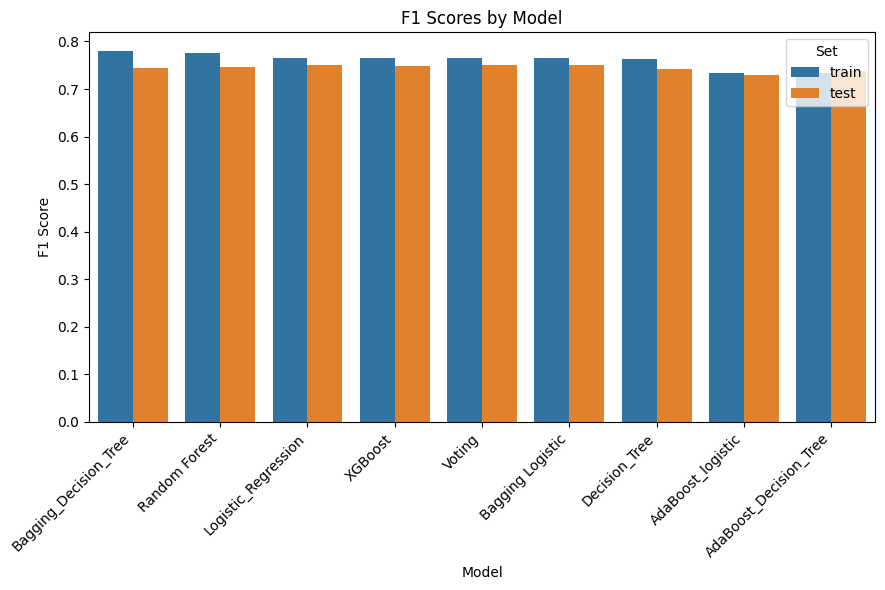

In [ ]:
plt.figure(figsize=(9, 6))    # Figure size

sns.barplot(data=df_scores, x='model', y='f1_score', hue='set')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('F1 Scores by Model')

plt.xticks(rotation=45, ha='right')  # Rotate and align the x-axis labels to prevent overlap

plt.legend(title='Set')
plt.tight_layout()

plt.show()

# Save F1_results to a csv file

In [ ]:
df_scores.to_csv('Models_F1_results')


# 5) Coefficients impact

In [ ]:
column_names = []

for name, step, features_list in Preprocessor.transformers_: # loop over steps of ColumnTransformer
    if name == 'num': # if pipeline is for numeric variables
        features = features_list # just get the names of columns to which it has been applied
    else: # if pipeline is for categorical variables
        features = step.get_feature_names_out() # get output columns names from OneHotEncoder

    column_names.extend(features) # concatenate features names

print("Names of columns corresponding to each coefficient: ", column_names)
#ridsearch_bagging_tree.best_estimator_.estimators_features_.
# Create a pandas DataFrame
feature_importance = pd.DataFrame(index = column_names, data = gridsearch_decision_tree.best_estimator_.feature_importances_, columns=["feature_importances"])
feature_importance = feature_importance.sort_values(by = 'feature_importances', ascending = False)


Names of columns corresponding to each coefficient:  ['total_pages_visited', 'age', 'country_Germany', 'country_UK', 'country_US', 'source_Direct', 'source_Seo', 'new_user_1']


In [ ]:
feature_importance

,feature_importances
total_pages_visited,0.873778
new_user_1,0.061182
age,0.029753
country_UK,0.012291
country_US,0.011998
country_Germany,0.008294
source_Direct,0.001571
source_Seo,0.001134


THe featue importance as per the table below, the least important is the SEO source and the most important two are the total pages visited and if new user

Final note on the analysis related to the features importance above, I have chosen the deicion tree to exctract the importance. if we need to do the same on the bagging decision tree for instance we need to implement a loop that goes through the whole estimators and aggregate the results. But in my opinion after observing the results above aparently the difference in weight is large and clear.

# 6) Exporting the prediction results

### 6.a) importing the test set

In [ ]:
real_test = pd.read_csv('conversion_data_test.csv')

In [ ]:
real_test.head()

,country,age,new_user,source,total_pages_visited
0,UK,28,0,Seo,16
1,UK,22,1,Direct,5
2,China,32,1,Seo,1
3,US,32,1,Ads,6
4,China,25,0,Seo,3


### 6.b) Preprocessing

In [ ]:
real_test = Preprocessor.transform(real_test)

# print(real_test)


6.c) Implementing prediction using the logistic regression model

In [ ]:
real_result = model_logisticRegression.predict(real_test)

In [ ]:
# Transfer to pandas dataframe
final = pd.DataFrame(real_result)

In [ ]:
final.head()

,0
0,1
1,0
2,0
3,0
4,0


Rename the column header

In [ ]:
final.rename(columns={0: "converted"}, inplace=True)


In [ ]:
final.head()

,converted
0,1
1,0
2,0
3,0
4,0


In [ ]:
final.to_csv('conversion_data_test_predictions_Lionel_Simple.csv', index=False)

6.d) Predicion using Bagging Decision Tree

In [ ]:
real_result = gridsearch_bagging_tree.predict(real_test)

In [ ]:
# Transfer to pandas dataframe
final = pd.DataFrame(real_result)

In [ ]:
final.head()

,0
0,1
1,0
2,0
3,0
4,0


In [ ]:
final.rename(columns={0: "converted"}, inplace=True)


In [ ]:
final.head()

,converted
0,1
1,0
2,0
3,0
4,0


In [ ]:
final.to_csv('conversion_data_test_predictions_Bagging_Tree_Lionel.csv', index=False)

##########

# Appendix

In [ ]:
from sklearn.metrics import classification_report


print(classification_report(Y_train, Y_train_pred))
print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    220156
           1       0.86      0.69      0.76      7342

    accuracy                           0.99    227498
   macro avg       0.92      0.84      0.88    227498
weighted avg       0.99      0.99      0.99    227498

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     55040
           1       0.85      0.66      0.74      1835

    accuracy                           0.99     56875
   macro avg       0.92      0.83      0.87     56875
weighted avg       0.98      0.99      0.98     56875



# The template

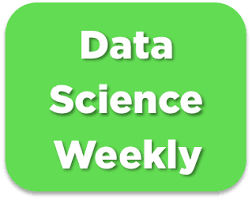

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler ,  OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.pipeline import Pipeline



import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

# Read file with labels

In [ ]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [ ]:
data.describe()

,age,new_user,total_pages_visited,converted
count,284580.000000,284580.000000,284580.000000,284580.000000
mean,30.564203,0.685452,4.873252,0.032258
std,8.266789,0.464336,3.341995,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [ ]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


# Explore dataset

In [ ]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000)

# Make your model

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [ ]:
features_list = ['total_pages_visited']
numeric_indices = [0]
categorical_indices = []
target_variable = 'converted'

In [ ]:
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['total_pages_visited'], dtype='object')



In [ ]:
# Divide dataset Train set & Test set
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



## Training pipeline

In [ ]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")

featureencoder = StandardScaler()
X_train = featureencoder.fit_transform(X_train)
print("...Done")
print(X_train[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.26070136]
 [ 0.93728655]
 [-0.85969532]
 [-0.56019834]
 [-0.26070136]]


In [ ]:
# Train model
print("Train model...")
classifier = LogisticRegression() #
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...


...Done.


In [ ]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



## Test pipeline

In [ ]:
# Use X_test, and the same preprocessings as in training pipeline,
# but call "transform()" instead of "fit_transform" methods (see example below)

print("Encoding categorical features and standardizing numerical features...")

X_test = featureencoder.transform(X_test)
print("...Done")
print(X_test[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 0.63778957]
 [ 0.03879562]
 [-0.26070136]
 [-0.26070136]
 [ 0.63778957]]


In [ ]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



## Performance assessment

In [ ]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.6938517686692869
f1-score on test set :  0.7060240963855423


In [ ]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[246817   1082]
 [  3280   4943]]

Confusion matrix on test set : 
[[27384   117]
 [  371   586]]



**Our baseline model reaches a f1-score of almost 70%. Now, feel free to refine your model and try to beat this score ! 🚀🚀**

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [ ]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier.fit(X,Y)

LogisticRegression()

In [ ]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features
# used by your best classifier)
features_list = ['total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])

Prediction set (without labels) : (31620, 5)
Convert pandas DataFrames to numpy arrays...
...Done
[[16]
 [ 5]
 [ 1]
 [ 6]
 [ 3]]


In [ ]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = featureencoder.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 3.33326238]
 [ 0.03879562]
 [-1.15919229]
 [ 0.3382926 ]
 [-0.56019834]]


In [ ]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_EXAMPLE.csv', index=False)


## Analyzing the coefficients and interpreting the result
**In this template, we just trained a model with only one feature (total_pages_visited), so there's no analysis to be done about the feature importance 🤔**

**Once you've included more features in your model, please take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**

In [ ]:
display(100*data.isnull().sum()/data.shape[0])
#display(100*dataset.isnull().sum()/dataset.shape[0])


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

In [ ]:
data.describe(include='all')

,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


In [ ]:
df['age'].val

30.0

In [ ]:
df = data

In [ ]:
mask = df['age'] <= 60
df = df.loc[mask,:]

In [ ]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [ ]:
df.describe()

,age,new_user,total_pages_visited,converted
count,284373.000000,284373.000000,284373.000000,284373.000000
mean,30.540199,0.685473,4.873437,0.032271
std,8.220222,0.464328,3.342442,0.176719
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,60.000000,1.000000,29.000000,1.000000


In [ ]:
corr_matrix = df.corr().round(2)

In [ ]:
import plotly .figure_factory as ff

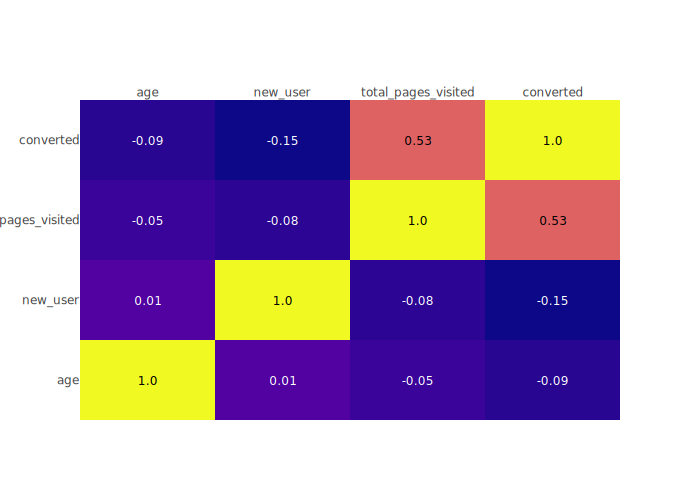

In [ ]:
fig = ff.create_annotated_heatmap(corr_matrix.values, x=corr_matrix.columns.tolist(),y=corr_matrix.index.tolist())
fig.show()